In [1]:
import os
import sys
import time
import timeit
import torch
import pprint
import pathlib
import logging

import numpy as np
from torch import nn
import albumentations
from tqdm import tqdm
from models.hrnet import HRNet
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from utils.transformations import re_normalize
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval, testvideo
from utils.data_utils import get_labels, label_mapping, SegmentationDataset, display
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformation_pipelines import (get_transforms_training, get_transforms_validation, 
                                            get_transforms_evaluation, get_transforms_video)
from configs.hrnet_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

def cityscapes_label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for key, val in trainid2label.items():
        indices = mask == key
        mask_rgb[indices.squeeze()] = val.color 
    return mask_rgb

In [3]:
transforms_training = get_transforms_training(cfg)
transforms_validation = get_transforms_validation(cfg)
transforms_evaluation = get_transforms_evaluation(cfg)
transforms_video = get_transforms_video(cfg)

In [4]:
train_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_validation)
eval_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_evaluation)
video_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "demoVideo", transform = transforms_video, labels=False)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = cfg.TRAIN.BATCH_SIZE, 
                              shuffle = True, num_workers = 0)

valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = cfg.TRAIN.BATCH_SIZE, 
                              shuffle = True, num_workers = 0)

eval_dataloader = DataLoader(dataset = eval_dataset, batch_size = 1, 
                             shuffle = False, num_workers = 0)

video_dataloader = DataLoader(dataset = video_dataset, batch_size = 1, 
                              shuffle = False, num_workers = 0)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))
xt, yt, _, tnames = next(iter(eval_dataloader))
xvd, _, tnames = next(iter(video_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

x.shape: (12, 3, 512, 1024), x.type: torch.float32, [min(x), max(x)]: [-2.118, 2.640]
y.shape: (12, 512, 1024), y.type: torch.int64 
y unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 255]


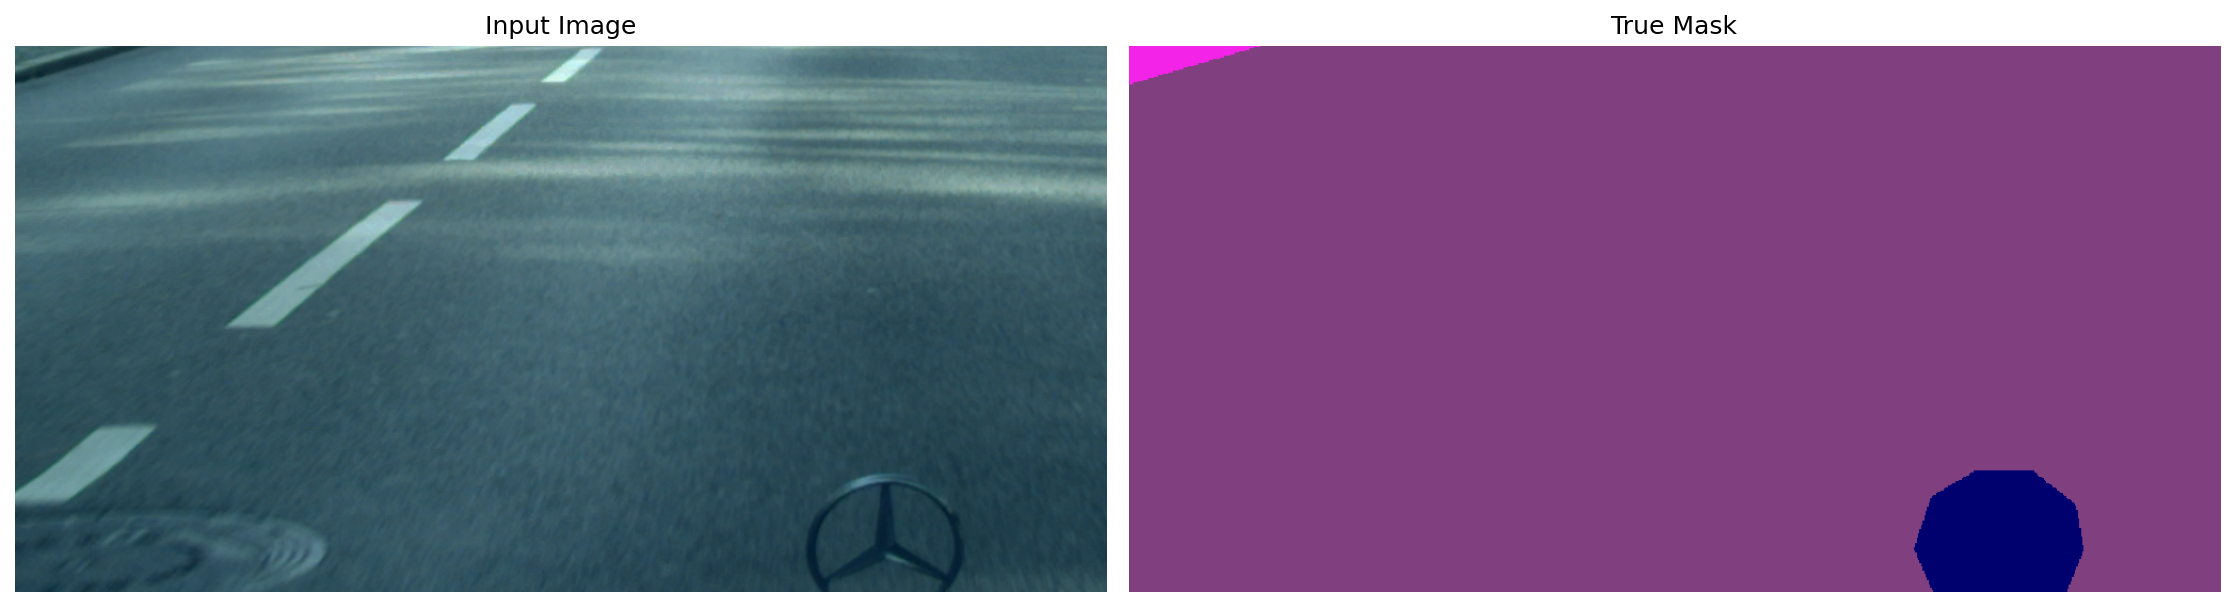

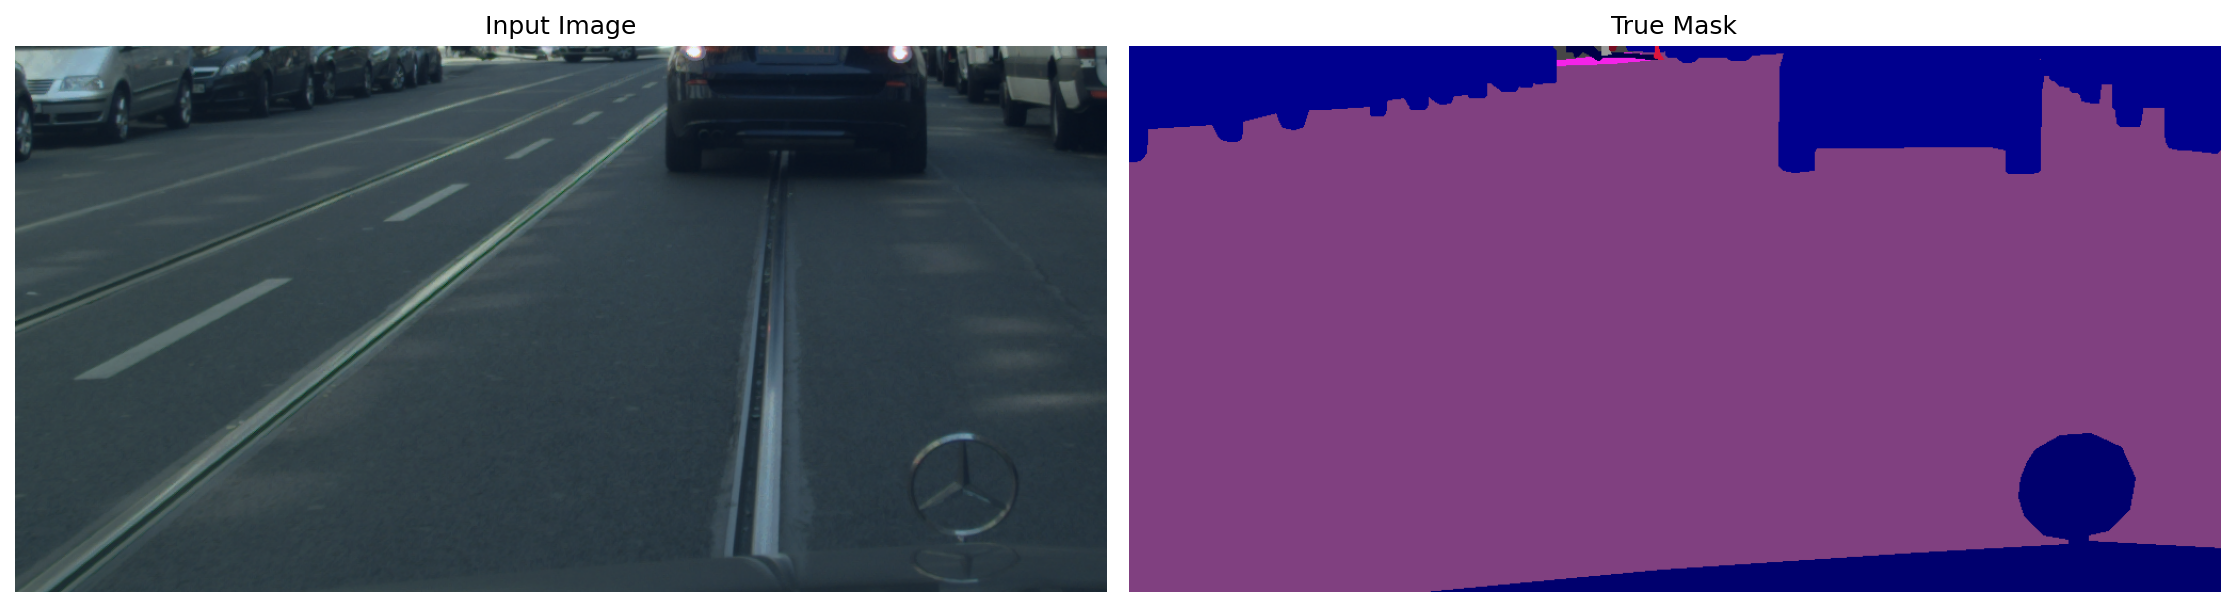

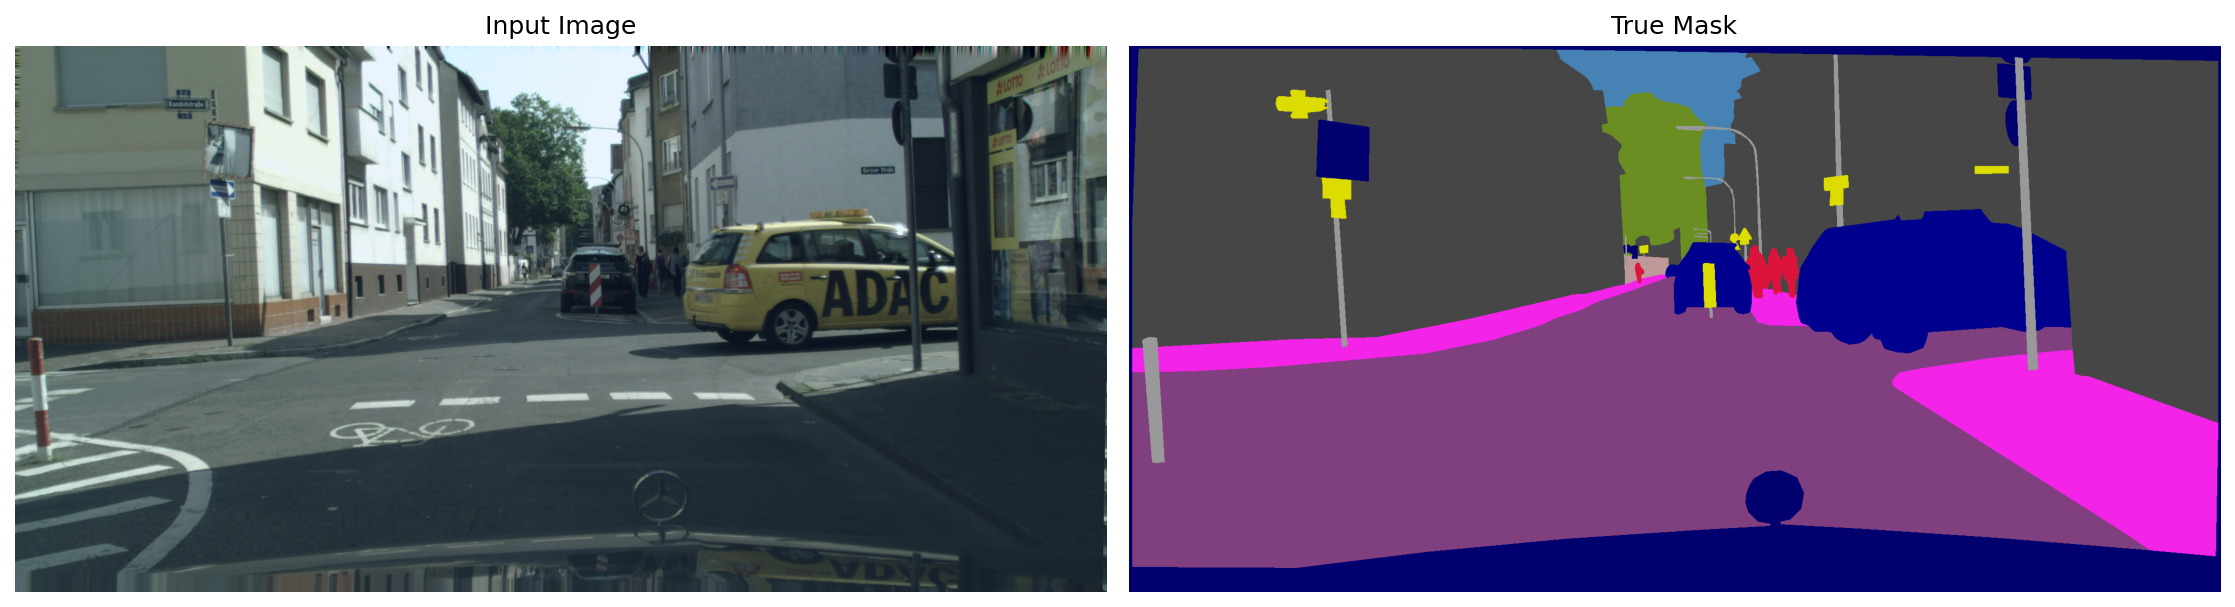

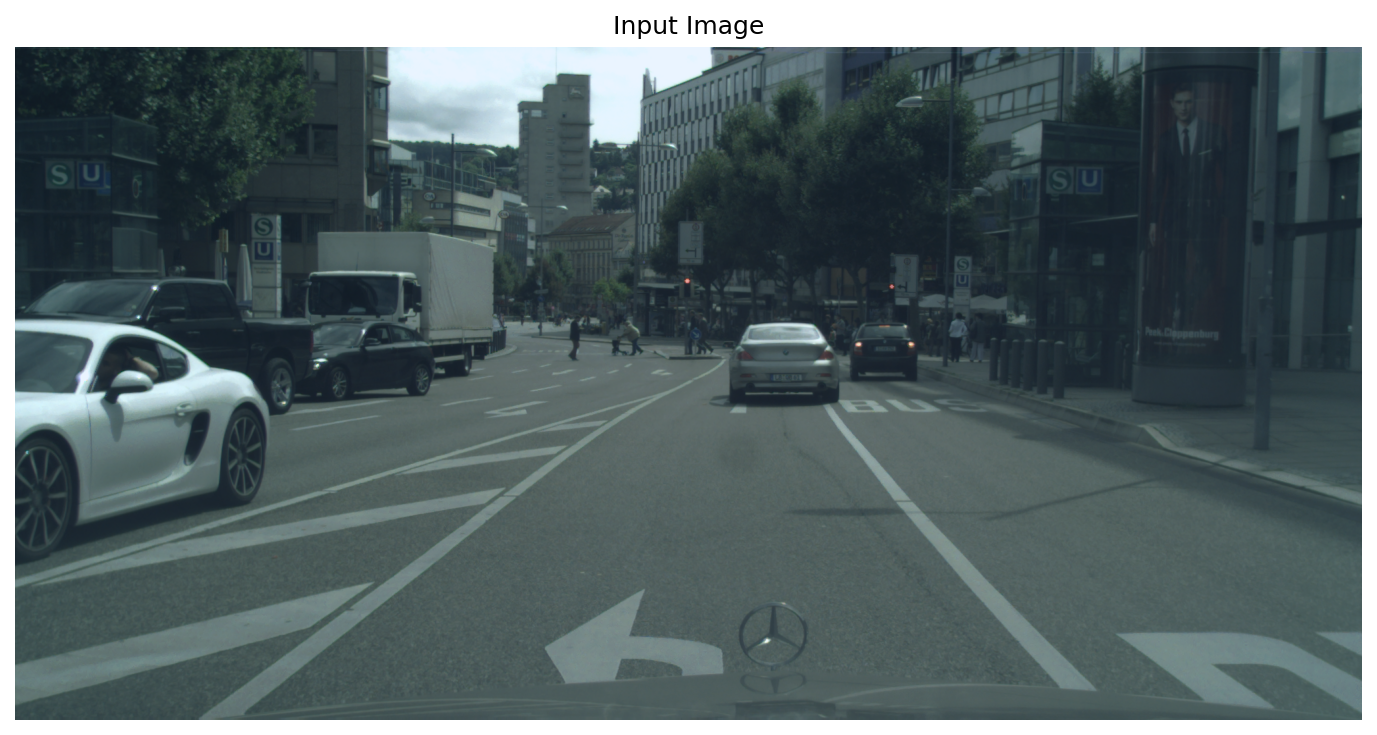

In [5]:
idx = 0
display([re_normalize(x[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(y[idx])])
display([re_normalize(xv[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yv[idx])])
display([re_normalize(xt[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yt[idx])])
display([re_normalize(xvd[idx].permute(1,2,0).numpy())])

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = HRNet(cfg).to(device)

criterion = CrossEntropy(
    ignore_label=cfg.DATASET.IGNORE_LABEL, 
    weight=train_dataset.class_weights
)#.cuda()

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=cfg.TRAIN.BASE_LR, 
    momentum=cfg.TRAIN.MOMENTUM, 
    weight_decay=cfg.TRAIN.WD
)

# model.init_weights(pretrained = cfg.MODEL.PRETRAINED)

In [ ]:
model.load_state_dict(torch.load("weights/hrnet_w48.pth", map_location=torch.device('cpu')))
model.eval()

# checkpoint = torch.load("weights/hrnet_w48.pth.tar", map_location=torch.device('cpu'))
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [ ]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(
        config, 
        cfg_name="seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484", 
        phase='train'
    )
    
    # dump_input = torch.rand((1, 3, 512, 1024))
    # logger.info(get_model_summary(model.cuda(), dump_input.cuda()))

    writer_dict = {
        'writer': SummaryWriter(tb_log_dir),
        'train_global_steps': 0,
        'valid_global_steps': 0,
    }

    best_mIoU = 0

    start = timeit.default_timer()
    for epoch in range(cfg.TRAIN.EPOCHS):

        train(
            config=config, 
            dataloader=train_dataloader, 
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            config=config, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth'))

        msg = 'Epoch {}/{} --- Loss: {:.3f}, MeanIU: {: 4.4f}, Best_mIoU: {: 4.4f} \n'.format(
            epoch+1, cfg.TRAIN.EPOCHS, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
# run_train_loop()

In [ ]:
testvideo(config, video_dataloader, model, sv_dir='outputs', sv_pred=True)

In [ ]:
# mean_IoU, IoU_array, pixel_acc, mean_acc = testval(config, eval_dataloader, model, sv_dir='', sv_pred=True)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != config['IGNORE_LABEL'] and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))